# Drive mount

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("./drive/MyDrive/git_project/TextClassification/src")

Mounted at /content/drive


# Show data list

In [2]:
os.listdir("../data")

['train.csv',
 'test.csv',
 'sample_submission.csv',
 'test_labels.csv',
 'sample_submission.csv.zip',
 'test.csv.zip',
 'train.csv.zip',
 'test_labels.csv.zip',
 'jigsaw-toxic-comment-classification-challenge.zip']

# Import modules

In [4]:
! pip install transformers
! pip install keras-self-attention

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re

nltk.download("punkt")
import torch
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, GRU, Embedding, Dense, Bidirectional, LayerNormalization, BatchNormalization, Dropout, Flatten, LSTM, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_self_attention import SeqSelfAttention
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split


from itertools import chain
from collections import Counter
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import gensim.downloader


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True); print(f"tf version:{tf.__version__}")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=59ebdcb328cec969cc796154ccf3ae35a7356ecc1569e47b12084894d5c81039
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


tf version:2.13.0


# Read files

In [5]:
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")
sample_submission = pd.read_csv("../data/sample_submission.csv")

# Check duplicated id set

In [6]:
# if no duplicated id set..
assert train_data["id"].shape == train_data["id"].unique().shape
assert test_data["id"].shape == test_data["id"].unique().shape

# test id includes train id
assert len((set(train_data["id"]) - set(test_data["id"]))) == train_data["id"].shape[0]

# train id includes test id
assert len((set(test_data["id"]) - set(train_data["id"]))) == test_data["id"].shape[0]

In [7]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [9]:
all_labels = train_data.iloc[0,2:].index.to_list()
all_labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [10]:
train_data.iloc[:,2:].sum(axis=0).sort_values(ascending=False)

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

# Word length frequency

<Axes: ylabel='Frequency'>

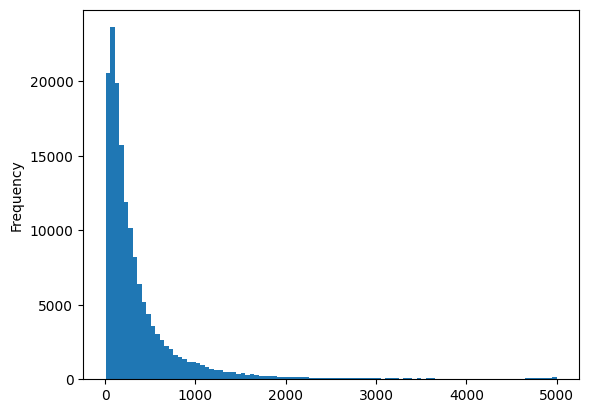

In [11]:
train_data["comment_text"].str.len().plot(kind="hist", bins=100)

In [12]:
train_data["comment_text"].str.len().describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_text, dtype: float64

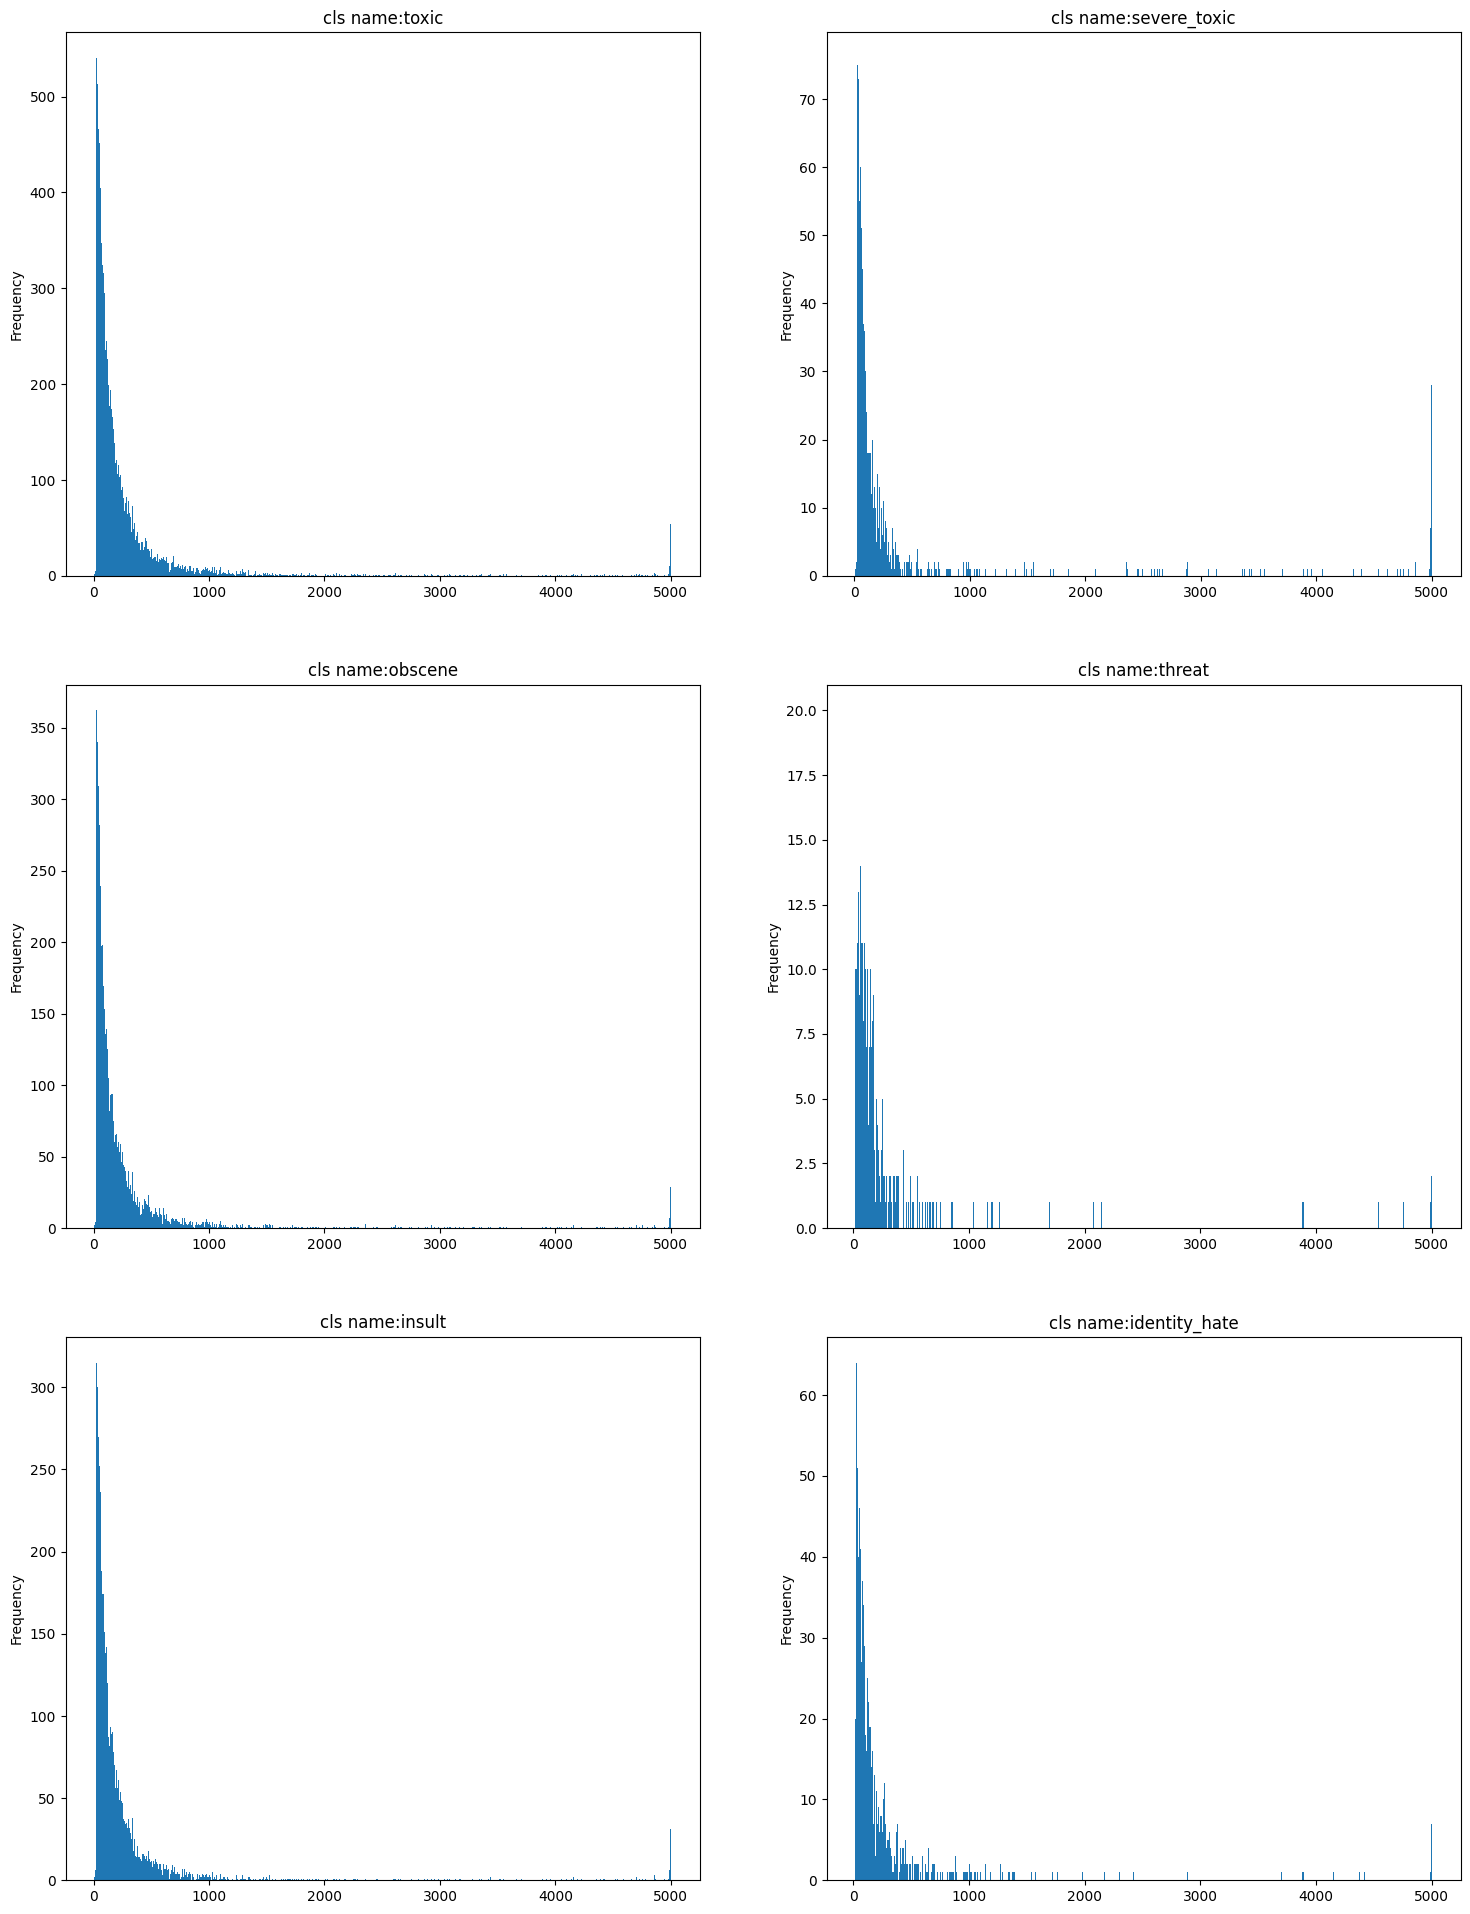

In [66]:
import matplotlib.pyplot as plt
import numpy as np
all_fig_num = len(all_labels)
col_num = int(np.ceil(all_fig_num / 2))
row_num = 2
fig = plt.figure(figsize=(18, 8*col_num))

for index, cls in enumerate(all_labels):
    ax = fig.add_subplot(col_num, row_num, index+1)
    ax.set_title(f"cls name:{cls}")
    train_data.loc[train_data[cls] == 1, "comment_text"].str.len().plot(kind="hist", ax=ax, bins=1000)

In [13]:
SHUFFLE_BUFFER = 256
BATCH_SIZE = 256
MODEL_PATH = "../model/model_dl_clf.h5"
AUTOTUNE = tf.data.AUTOTUNE

In [22]:
label_encoder.transform([["toxic", "insult"]])

array([[0, 1, 0, 0, 0, 1]])

In [21]:
np.array(all_labels).reshape(-1, 1)

array([['toxic'],
       ['severe_toxic'],
       ['obscene'],
       ['threat'],
       ['insult'],
       ['identity_hate']], dtype='<U13')

In [14]:
label_encoder = MultiLabelBinarizer()
label_encoder.fit(np.array(all_labels).reshape(-1, 1))
# train_labels_encoded = label_encoder.transform(train_df["classes"])
# test_labels_encoded = label_encoder.transform(test_df["classes"])

MultiLabelBinarizer()

In [ ]:
# train_labels = pd.DataFrame(train_labels_encoded, columns=label_encoder.classes_)
# test_labels = pd.DataFrame(test_labels_encoded, columns=label_encoder.classes_)
# train_labels = train_labels[ALL_LABELS]
# test_labels = test_labels[ALL_LABELS]
# train_df = pd.concat([train_df, train_labels], axis=1)
# test_df = pd.concat([test_df, test_labels], axis=1)

In [30]:
# Show all available models in gensim-data
print(list(gensim.downloader.info()["models"].keys()))
w2v_model = gensim.downloader.load("glove-twitter-25")

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']
[==================================================] 100.0% 104.8/104.8MB downloaded


In [55]:
index2word = {index+1 : key for key, index in w2v_model.key_to_index.items()}
word2index = {key : index+1 for key, index in w2v_model.key_to_index.items()}
embedding_vector = np.zeros((len(index2word) + 2, w2v_model.vector_size))
for i, w in tqdm(index2word.items()):
    embedding_vector[i] = w2v_model.__getitem__(w)
# someting method likes attention masking
embedding_vector[-1] = 1
embedding_vector

100%|██████████| 1193514/1193514 [00:02<00:00, 461046.94it/s]


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.62414998,  0.62475997, -0.082335  , ..., -0.48469001,
         0.40077999,  0.75344998],
       [ 0.69586003, -1.14690006, -0.41797   , ..., -0.67877001,
         0.70609999,  0.40832999],
       ...,
       [-0.44589001, -3.55890012, -0.25854   , ..., -0.67203999,
         3.40370011, -0.16321   ],
       [-2.58069992, -1.09650004, -0.59056002, ...,  1.71229994,
         0.79866999,  0.32424   ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [61]:
reg_except = re.compile(r"[^a-zA-Z]|\s+[a-zA-Z]\s+|\s+")
def preprocess_text(txt):
    return reg_except.sub(" ", txt.lower())

def tokenize(txt):
    return word_tokenize(txt)

def to_sequence(tokenized_list):
    seqs = []
    for token in tokenized_list:
        seqs.append(word2index.get(token, UNKNOWN_INDEX))
    return seqs

UNKNOWN_INDEX = len(index2word) + 1

preprocessed = train_data["comment_text"].map(preprocess_text)
preprocessed = [tokenize(_p) for _p in preprocessed]
preprocessed = [to_sequence(_p) for _p in preprocessed]
seq_len = [len(p) for p in preprocessed]
print(pd.Series(seq_len).describe())
PADDING_MAX = 50

count    159571.000000
mean         68.166026
std         100.981046
min           0.000000
25%          17.000000
50%          36.000000
75%          76.000000
max        1403.000000
dtype: float64


In [62]:
train_data["sequence"] = pad_sequences(preprocessed, padding='post', maxlen=PADDING_MAX).tolist()

preprocessed = test_data["comment_text"].map(preprocess_text)
preprocessed = [tokenize(_p) for _p in preprocessed]
preprocessed = [to_sequence(_p) for _p in preprocessed]
test_data["sequence"] = pad_sequences(preprocessed, padding='post', maxlen=PADDING_MAX).tolist()

In [63]:
train, val = train_test_split(train_data, random_state=91, test_size=0.1)

train_x = np.vstack(train["sequence"].values)
train_y = np.vstack(train.iloc[:, 2:-1].values)

val_x = np.vstack(val["sequence"].values)
val_y = np.vstack(val.iloc[:, 2:-1].values)
print(train_x.shape, val_x.shape, train_y.shape, val_y.shape)

(143613, 50) (15958, 50) (143613, 6) (15958, 6)


In [68]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        train_x.tolist(),
        train_y.tolist()
    )
)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (
        val_x.tolist(),
        val_y.tolist()
    )
)

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER)\
            .batch(BATCH_SIZE)\
            .prefetch(AUTOTUNE)
val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER)\
            .batch(BATCH_SIZE)\
            .prefetch(AUTOTUNE)

In [70]:
vocab_size = embedding_vector.shape[0]
vector_size = embedding_vector.shape[1]
inputs = Input(shape=(train_x.shape[1]))
layer = Embedding(
    vocab_size,
    vector_size,
    weights=[embedding_vector],
    trainable=False
)(inputs)

layer = SeqSelfAttention()(layer)
layer = Bidirectional(GRU(128))(layer)
layer = Dense(128, activation="relu")(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.3)(layer)
layer = Dense(64, activation="relu")(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.3)(layer)
layer = Dense(train_y.shape[1], activation="sigmoid")(layer)
model = Model(inputs, layer)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 25)            29837900  
                                                                 
 seq_self_attention_1 (SeqS  (None, 50, 25)            1665      
 elfAttention)                                                   
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               119040    
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512 

In [71]:
def metric_custom(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(K.greater(y_pred, 0.5), tf.float32)
    return K.mean(tf.cast(y_pred == y_true, tf.float32), axis=1)

In [72]:
model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[metric_custom]
    )
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3
    ),
    ModelCheckpoint(
        filepath=MODEL_PATH,
        vervose=1,
        save_best_only=True
    )
]
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
559/561 [============================>.] - ETA: 0s - loss: 0.2460 - metric_custom: 0.9120

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


561/561 [==============================] - 23s 19ms/step - loss: 0.2455 - metric_custom: 0.9122 - val_loss: 0.0733 - val_metric_custom: 0.9772
Epoch 2/30
561/561 [==============================] - 10s 18ms/step - loss: 0.0762 - metric_custom: 0.9759 - val_loss: 0.0629 - val_metric_custom: 0.9790
Epoch 3/30
561/561 [==============================] - 10s 17ms/step - loss: 0.0673 - metric_custom: 0.9774 - val_loss: 0.0632 - val_metric_custom: 0.9785
Epoch 4/30
561/561 [==============================] - 12s 21ms/step - loss: 0.0641 - metric_custom: 0.9781 - val_loss: 0.0629 - val_metric_custom: 0.9790
Epoch 5/30
561/561 [==============================] - 10s 18ms/step - loss: 0.0621 - metric_custom: 0.9786 - val_loss: 0.0611 - val_metric_custom: 0.9788
Epoch 6/30
561/561 [==============================] - 10s 19ms/step - loss: 0.0611 - metric_custom: 0.9790 - val_loss: 0.0609 - val_metric_custom: 0.9792
Epoch 7/30
561/561 [==============================] - 10s 18ms/step - loss: 0.0598 - me

In [125]:
test_dataset = tf.data.Dataset.from_tensor_slices(
    (
        test_data["sequence"].values.tolist(),
    )
)

test_dataset = test_dataset\
            .batch(BATCH_SIZE)\
            .prefetch(AUTOTUNE)

In [126]:
model.load_weights(MODEL_PATH)
pred = []
acc = 0
for batch in tqdm(test_dataset):
    pred.append(np.where(model.predict(batch[0]) > 0.5, 1.0, 0.0))

pred = np.vstack(pred)
pred

  0%|          | 0/599 [00:00<?, ?it/s]

8/8 [==============================] - 0s 4ms/step


  0%|          | 1/599 [00:00<01:11,  8.38it/s]

8/8 [==============================] - 0s 4ms/step


  1%|          | 3/599 [00:00<00:59,  9.98it/s]

8/8 [==============================] - 0s 4ms/step


  1%|          | 5/599 [00:00<00:57, 10.37it/s]

8/8 [==============================] - 0s 4ms/step


  1%|          | 7/599 [00:00<00:56, 10.39it/s]

8/8 [==============================] - 0s 4ms/step


  2%|▏         | 9/599 [00:00<00:56, 10.48it/s]

8/8 [==============================] - 0s 4ms/step


  2%|▏         | 11/599 [00:01<00:57, 10.31it/s]

8/8 [==============================] - 0s 4ms/step


  2%|▏         | 13/599 [00:01<00:56, 10.46it/s]

8/8 [==============================] - 0s 4ms/step


  3%|▎         | 15/599 [00:01<00:55, 10.55it/s]

8/8 [==============================] - 0s 4ms/step


  3%|▎         | 17/599 [00:01<00:54, 10.62it/s]

8/8 [==============================] - 0s 4ms/step


  3%|▎         | 19/599 [00:01<00:54, 10.58it/s]

8/8 [==============================] - 0s 4ms/step


  4%|▎         | 21/599 [00:02<00:54, 10.53it/s]

8/8 [==============================] - 0s 4ms/step


  4%|▍         | 23/599 [00:02<00:54, 10.54it/s]

8/8 [==============================] - 0s 4ms/step


  4%|▍         | 25/599 [00:02<00:53, 10.65it/s]

8/8 [==============================] - 0s 4ms/step


  5%|▍         | 27/599 [00:02<00:54, 10.59it/s]

8/8 [==============================] - 0s 4ms/step


  5%|▍         | 29/599 [00:02<00:53, 10.74it/s]

8/8 [==============================] - 0s 4ms/step


  5%|▌         | 31/599 [00:02<00:52, 10.84it/s]

8/8 [==============================] - 0s 4ms/step


  6%|▌         | 33/599 [00:03<00:51, 10.97it/s]

8/8 [==============================] - 0s 4ms/step


  6%|▌         | 35/599 [00:03<00:51, 10.86it/s]

8/8 [==============================] - 0s 4ms/step


  6%|▌         | 37/599 [00:03<00:51, 10.98it/s]

8/8 [==============================] - 0s 4ms/step


  7%|▋         | 39/599 [00:03<00:50, 11.08it/s]

8/8 [==============================] - 0s 4ms/step


  7%|▋         | 41/599 [00:03<00:49, 11.17it/s]

8/8 [==============================] - 0s 4ms/step


  7%|▋         | 43/599 [00:04<00:50, 11.07it/s]

8/8 [==============================] - 0s 4ms/step


  8%|▊         | 45/599 [00:04<00:49, 11.24it/s]

8/8 [==============================] - 0s 4ms/step


  8%|▊         | 47/599 [00:04<00:48, 11.31it/s]

8/8 [==============================] - 0s 4ms/step


  8%|▊         | 49/599 [00:04<00:48, 11.43it/s]

8/8 [==============================] - 0s 4ms/step


  9%|▊         | 51/599 [00:04<00:48, 11.30it/s]

8/8 [==============================] - 0s 4ms/step


  9%|▉         | 53/599 [00:04<00:47, 11.39it/s]

8/8 [==============================] - 0s 4ms/step


  9%|▉         | 55/599 [00:05<00:47, 11.51it/s]

8/8 [==============================] - 0s 4ms/step


 10%|▉         | 57/599 [00:05<00:46, 11.54it/s]

8/8 [==============================] - 0s 4ms/step


 10%|▉         | 59/599 [00:05<00:47, 11.44it/s]

8/8 [==============================] - 0s 4ms/step


 10%|█         | 61/599 [00:05<00:46, 11.52it/s]

8/8 [==============================] - 0s 4ms/step


 11%|█         | 63/599 [00:05<00:46, 11.55it/s]

8/8 [==============================] - 0s 4ms/step


 11%|█         | 65/599 [00:05<00:46, 11.49it/s]

8/8 [==============================] - 0s 4ms/step


 11%|█         | 67/599 [00:06<00:46, 11.36it/s]

8/8 [==============================] - 0s 4ms/step


 12%|█▏        | 69/599 [00:06<00:46, 11.47it/s]

8/8 [==============================] - 0s 4ms/step


 12%|█▏        | 71/599 [00:06<00:45, 11.49it/s]

8/8 [==============================] - 0s 4ms/step


 12%|█▏        | 73/599 [00:06<00:45, 11.52it/s]

8/8 [==============================] - 0s 4ms/step


 13%|█▎        | 75/599 [00:06<00:46, 11.38it/s]

8/8 [==============================] - 0s 4ms/step


 13%|█▎        | 77/599 [00:06<00:45, 11.46it/s]

8/8 [==============================] - 0s 4ms/step


 13%|█▎        | 79/599 [00:07<00:45, 11.47it/s]

8/8 [==============================] - 0s 4ms/step


 14%|█▎        | 81/599 [00:07<00:44, 11.57it/s]

8/8 [==============================] - 0s 4ms/step


 14%|█▍        | 83/599 [00:07<00:45, 11.31it/s]

8/8 [==============================] - 0s 4ms/step


 14%|█▍        | 85/599 [00:07<00:45, 11.36it/s]

8/8 [==============================] - 0s 4ms/step


 15%|█▍        | 87/599 [00:07<00:44, 11.40it/s]

8/8 [==============================] - 0s 4ms/step


 15%|█▍        | 89/599 [00:08<00:44, 11.34it/s]

8/8 [==============================] - 0s 4ms/step


 15%|█▌        | 91/599 [00:08<00:45, 11.23it/s]

8/8 [==============================] - 0s 4ms/step


 16%|█▌        | 93/599 [00:08<00:44, 11.27it/s]

8/8 [==============================] - 0s 4ms/step


 16%|█▌        | 95/599 [00:08<00:44, 11.28it/s]

8/8 [==============================] - 0s 4ms/step


 16%|█▌        | 97/599 [00:08<00:44, 11.31it/s]

8/8 [==============================] - 0s 4ms/step


 17%|█▋        | 99/599 [00:08<00:44, 11.25it/s]

8/8 [==============================] - 0s 4ms/step


 17%|█▋        | 101/599 [00:09<00:44, 11.25it/s]

8/8 [==============================] - 0s 4ms/step


 17%|█▋        | 103/599 [00:09<00:43, 11.37it/s]

8/8 [==============================] - 0s 4ms/step


 18%|█▊        | 105/599 [00:09<00:42, 11.50it/s]

8/8 [==============================] - 0s 4ms/step


 18%|█▊        | 107/599 [00:09<00:43, 11.34it/s]

8/8 [==============================] - 0s 4ms/step


 18%|█▊        | 109/599 [00:09<00:43, 11.35it/s]

8/8 [==============================] - 0s 4ms/step


 19%|█▊        | 111/599 [00:09<00:43, 11.27it/s]

8/8 [==============================] - 0s 4ms/step


 19%|█▉        | 113/599 [00:10<00:43, 11.24it/s]

8/8 [==============================] - 0s 4ms/step


 19%|█▉        | 115/599 [00:10<00:43, 11.24it/s]

8/8 [==============================] - 0s 4ms/step


 20%|█▉        | 117/599 [00:10<00:42, 11.35it/s]

8/8 [==============================] - 0s 4ms/step


 20%|█▉        | 119/599 [00:10<00:42, 11.36it/s]

8/8 [==============================] - 0s 4ms/step


 20%|██        | 121/599 [00:10<00:41, 11.40it/s]

8/8 [==============================] - 0s 4ms/step


 21%|██        | 123/599 [00:11<00:41, 11.41it/s]

8/8 [==============================] - 0s 4ms/step


 21%|██        | 125/599 [00:11<00:41, 11.51it/s]

8/8 [==============================] - 0s 4ms/step


 21%|██        | 127/599 [00:11<00:40, 11.57it/s]

8/8 [==============================] - 0s 4ms/step


 22%|██▏       | 129/599 [00:11<00:40, 11.71it/s]

8/8 [==============================] - 0s 4ms/step


 22%|██▏       | 131/599 [00:11<00:39, 11.71it/s]

8/8 [==============================] - 0s 4ms/step


 22%|██▏       | 133/599 [00:11<00:39, 11.79it/s]

8/8 [==============================] - 0s 4ms/step


 23%|██▎       | 135/599 [00:12<00:38, 11.94it/s]

8/8 [==============================] - 0s 4ms/step


 23%|██▎       | 137/599 [00:12<00:38, 11.96it/s]

8/8 [==============================] - 0s 4ms/step


 23%|██▎       | 139/599 [00:12<00:38, 12.03it/s]

8/8 [==============================] - 0s 4ms/step


 24%|██▎       | 141/599 [00:12<00:37, 12.14it/s]

8/8 [==============================] - 0s 4ms/step


 24%|██▍       | 143/599 [00:12<00:37, 12.14it/s]

8/8 [==============================] - 0s 4ms/step


 24%|██▍       | 145/599 [00:12<00:37, 11.99it/s]

8/8 [==============================] - 0s 4ms/step


 25%|██▍       | 147/599 [00:13<00:37, 12.01it/s]

8/8 [==============================] - 0s 4ms/step


 25%|██▍       | 149/599 [00:13<00:37, 12.10it/s]

8/8 [==============================] - 0s 4ms/step


 25%|██▌       | 151/599 [00:13<00:36, 12.23it/s]

8/8 [==============================] - 0s 4ms/step


 26%|██▌       | 153/599 [00:13<00:36, 12.20it/s]

8/8 [==============================] - 0s 4ms/step


 26%|██▌       | 155/599 [00:13<00:36, 12.10it/s]

8/8 [==============================] - 0s 4ms/step


 26%|██▌       | 157/599 [00:13<00:36, 12.09it/s]

8/8 [==============================] - 0s 4ms/step


 27%|██▋       | 159/599 [00:14<00:36, 12.09it/s]

8/8 [==============================] - 0s 4ms/step


 27%|██▋       | 161/599 [00:14<00:36, 12.08it/s]

8/8 [==============================] - 0s 4ms/step


 27%|██▋       | 163/599 [00:14<00:36, 12.09it/s]

8/8 [==============================] - 0s 4ms/step


 28%|██▊       | 165/599 [00:14<00:35, 12.20it/s]

8/8 [==============================] - 0s 4ms/step


 28%|██▊       | 167/599 [00:14<00:35, 12.23it/s]

8/8 [==============================] - 0s 4ms/step


 28%|██▊       | 169/599 [00:14<00:35, 12.25it/s]

8/8 [==============================] - 0s 4ms/step


 29%|██▊       | 171/599 [00:15<00:35, 12.14it/s]

8/8 [==============================] - 0s 4ms/step


 29%|██▉       | 173/599 [00:15<00:35, 12.15it/s]

8/8 [==============================] - 0s 4ms/step


 29%|██▉       | 175/599 [00:15<00:34, 12.20it/s]

8/8 [==============================] - 0s 4ms/step


 30%|██▉       | 177/599 [00:15<00:34, 12.20it/s]

8/8 [==============================] - 0s 4ms/step


 30%|██▉       | 179/599 [00:15<00:34, 12.08it/s]

8/8 [==============================] - 0s 4ms/step


 30%|███       | 181/599 [00:15<00:34, 12.10it/s]

8/8 [==============================] - 0s 4ms/step


 31%|███       | 183/599 [00:15<00:34, 12.10it/s]

8/8 [==============================] - 0s 4ms/step


 31%|███       | 185/599 [00:16<00:34, 11.93it/s]

8/8 [==============================] - 0s 4ms/step


 31%|███       | 187/599 [00:16<00:34, 11.90it/s]

8/8 [==============================] - 0s 4ms/step


 32%|███▏      | 189/599 [00:16<00:34, 11.97it/s]

8/8 [==============================] - 0s 4ms/step


 32%|███▏      | 191/599 [00:16<00:33, 12.03it/s]

8/8 [==============================] - 0s 4ms/step


 32%|███▏      | 193/599 [00:16<00:33, 12.05it/s]

8/8 [==============================] - 0s 4ms/step


 33%|███▎      | 195/599 [00:17<00:33, 12.00it/s]

8/8 [==============================] - 0s 4ms/step


 33%|███▎      | 197/599 [00:17<00:33, 12.05it/s]

8/8 [==============================] - 0s 4ms/step


 33%|███▎      | 199/599 [00:17<00:33, 12.11it/s]

8/8 [==============================] - 0s 4ms/step


 34%|███▎      | 201/599 [00:17<00:32, 12.24it/s]

8/8 [==============================] - 0s 4ms/step


 34%|███▍      | 203/599 [00:17<00:33, 11.99it/s]

8/8 [==============================] - 0s 4ms/step


 34%|███▍      | 205/599 [00:17<00:32, 12.01it/s]

8/8 [==============================] - 0s 4ms/step


 35%|███▍      | 207/599 [00:17<00:32, 12.02it/s]

8/8 [==============================] - 0s 4ms/step


 35%|███▍      | 209/599 [00:18<00:32, 12.04it/s]

8/8 [==============================] - 0s 4ms/step


 35%|███▌      | 211/599 [00:18<00:32, 11.98it/s]

8/8 [==============================] - 0s 4ms/step


 36%|███▌      | 213/599 [00:18<00:32, 12.02it/s]

8/8 [==============================] - 0s 4ms/step


 36%|███▌      | 215/599 [00:18<00:31, 12.03it/s]

8/8 [==============================] - 0s 4ms/step


 36%|███▌      | 217/599 [00:18<00:31, 12.01it/s]

8/8 [==============================] - 0s 4ms/step


 37%|███▋      | 219/599 [00:18<00:31, 12.01it/s]

8/8 [==============================] - 0s 4ms/step


 37%|███▋      | 221/599 [00:19<00:31, 12.01it/s]

8/8 [==============================] - 0s 4ms/step


 37%|███▋      | 223/599 [00:19<00:31, 12.07it/s]

8/8 [==============================] - 0s 4ms/step


 38%|███▊      | 225/599 [00:19<00:30, 12.12it/s]

8/8 [==============================] - 0s 4ms/step


 38%|███▊      | 227/599 [00:19<00:30, 12.09it/s]

8/8 [==============================] - 0s 4ms/step


 38%|███▊      | 229/599 [00:19<00:30, 11.96it/s]

8/8 [==============================] - 0s 4ms/step


 39%|███▊      | 231/599 [00:19<00:30, 11.89it/s]

8/8 [==============================] - 0s 4ms/step


 39%|███▉      | 233/599 [00:20<00:30, 11.86it/s]

8/8 [==============================] - 0s 4ms/step


 39%|███▉      | 235/599 [00:20<00:30, 11.89it/s]

8/8 [==============================] - 0s 4ms/step


 40%|███▉      | 237/599 [00:20<00:30, 11.97it/s]

8/8 [==============================] - 0s 4ms/step


 40%|███▉      | 239/599 [00:20<00:30, 11.98it/s]

8/8 [==============================] - 0s 4ms/step


 40%|████      | 241/599 [00:20<00:29, 12.00it/s]

8/8 [==============================] - 0s 4ms/step


 41%|████      | 243/599 [00:21<00:30, 11.69it/s]

8/8 [==============================] - 0s 4ms/step


 41%|████      | 245/599 [00:21<00:30, 11.64it/s]

8/8 [==============================] - 0s 4ms/step


 41%|████      | 247/599 [00:21<00:29, 11.74it/s]

8/8 [==============================] - 0s 4ms/step


 42%|████▏     | 249/599 [00:21<00:30, 11.61it/s]

8/8 [==============================] - 0s 4ms/step


 42%|████▏     | 251/599 [00:21<00:30, 11.45it/s]

8/8 [==============================] - 0s 4ms/step


 42%|████▏     | 253/599 [00:21<00:30, 11.36it/s]

8/8 [==============================] - 0s 4ms/step


 43%|████▎     | 255/599 [00:22<00:30, 11.40it/s]

8/8 [==============================] - 0s 4ms/step


 43%|████▎     | 257/599 [00:22<00:30, 11.39it/s]

8/8 [==============================] - 0s 4ms/step


 43%|████▎     | 259/599 [00:22<00:29, 11.36it/s]

8/8 [==============================] - 0s 4ms/step


 44%|████▎     | 261/599 [00:22<00:29, 11.32it/s]

8/8 [==============================] - 0s 4ms/step


 44%|████▍     | 263/599 [00:22<00:29, 11.44it/s]

8/8 [==============================] - 0s 4ms/step


 44%|████▍     | 265/599 [00:22<00:29, 11.48it/s]

8/8 [==============================] - 0s 4ms/step


 45%|████▍     | 267/599 [00:23<00:29, 11.42it/s]

8/8 [==============================] - 0s 4ms/step


 45%|████▍     | 269/599 [00:23<00:29, 11.23it/s]

8/8 [==============================] - 0s 4ms/step


 45%|████▌     | 271/599 [00:23<00:29, 11.23it/s]

8/8 [==============================] - 0s 4ms/step


 46%|████▌     | 273/599 [00:23<00:28, 11.28it/s]

8/8 [==============================] - 0s 4ms/step


 46%|████▌     | 275/599 [00:23<00:28, 11.30it/s]

8/8 [==============================] - 0s 4ms/step


 46%|████▌     | 277/599 [00:24<00:28, 11.17it/s]

8/8 [==============================] - 0s 4ms/step


 47%|████▋     | 279/599 [00:24<00:28, 11.09it/s]

8/8 [==============================] - 0s 4ms/step


 47%|████▋     | 281/599 [00:24<00:28, 11.09it/s]

8/8 [==============================] - 0s 4ms/step


 47%|████▋     | 283/599 [00:24<00:28, 11.09it/s]

8/8 [==============================] - 0s 4ms/step


 48%|████▊     | 285/599 [00:24<00:28, 11.10it/s]

8/8 [==============================] - 0s 4ms/step


 48%|████▊     | 287/599 [00:24<00:27, 11.27it/s]

8/8 [==============================] - 0s 4ms/step


 48%|████▊     | 289/599 [00:25<00:27, 11.35it/s]

8/8 [==============================] - 0s 4ms/step


 49%|████▊     | 291/599 [00:25<00:26, 11.43it/s]

8/8 [==============================] - 0s 4ms/step


 49%|████▉     | 293/599 [00:25<00:26, 11.42it/s]

8/8 [==============================] - 0s 4ms/step


 49%|████▉     | 295/599 [00:25<00:26, 11.51it/s]

8/8 [==============================] - 0s 4ms/step


 50%|████▉     | 297/599 [00:25<00:26, 11.57it/s]

8/8 [==============================] - 0s 4ms/step


 50%|████▉     | 299/599 [00:25<00:26, 11.51it/s]

8/8 [==============================] - 0s 4ms/step


 50%|█████     | 301/599 [00:26<00:26, 11.41it/s]

8/8 [==============================] - 0s 4ms/step


 51%|█████     | 303/599 [00:26<00:25, 11.45it/s]

8/8 [==============================] - 0s 4ms/step


 51%|█████     | 305/599 [00:26<00:25, 11.48it/s]

8/8 [==============================] - 0s 4ms/step


 51%|█████▏    | 307/599 [00:26<00:25, 11.55it/s]

8/8 [==============================] - 0s 4ms/step


 52%|█████▏    | 309/599 [00:26<00:25, 11.42it/s]

8/8 [==============================] - 0s 4ms/step


 52%|█████▏    | 311/599 [00:26<00:25, 11.48it/s]

8/8 [==============================] - 0s 4ms/step


 52%|█████▏    | 313/599 [00:27<00:24, 11.47it/s]

8/8 [==============================] - 0s 4ms/step


 53%|█████▎    | 315/599 [00:27<00:24, 11.52it/s]

8/8 [==============================] - 0s 4ms/step


 53%|█████▎    | 317/599 [00:27<00:24, 11.44it/s]

8/8 [==============================] - 0s 4ms/step


 53%|█████▎    | 319/599 [00:27<00:24, 11.50it/s]

8/8 [==============================] - 0s 4ms/step


 54%|█████▎    | 321/599 [00:27<00:24, 11.53it/s]

8/8 [==============================] - 0s 4ms/step


 54%|█████▍    | 323/599 [00:28<00:23, 11.55it/s]

8/8 [==============================] - 0s 4ms/step


 54%|█████▍    | 325/599 [00:28<00:23, 11.42it/s]

8/8 [==============================] - 0s 4ms/step


 55%|█████▍    | 327/599 [00:28<00:23, 11.51it/s]

8/8 [==============================] - 0s 4ms/step


 55%|█████▍    | 329/599 [00:28<00:23, 11.59it/s]

8/8 [==============================] - 0s 4ms/step


 55%|█████▌    | 331/599 [00:28<00:22, 11.67it/s]

8/8 [==============================] - 0s 4ms/step


 56%|█████▌    | 333/599 [00:28<00:22, 11.60it/s]

8/8 [==============================] - 0s 4ms/step


 56%|█████▌    | 335/599 [00:29<00:22, 11.55it/s]

8/8 [==============================] - 0s 4ms/step


 56%|█████▋    | 337/599 [00:29<00:22, 11.60it/s]

8/8 [==============================] - 0s 4ms/step


 57%|█████▋    | 339/599 [00:29<00:22, 11.61it/s]

8/8 [==============================] - 0s 4ms/step


 57%|█████▋    | 341/599 [00:29<00:22, 11.48it/s]

8/8 [==============================] - 0s 4ms/step


 57%|█████▋    | 343/599 [00:29<00:22, 11.52it/s]

8/8 [==============================] - 0s 4ms/step


 58%|█████▊    | 345/599 [00:29<00:22, 11.51it/s]

8/8 [==============================] - 0s 4ms/step


 58%|█████▊    | 347/599 [00:30<00:21, 11.67it/s]

8/8 [==============================] - 0s 4ms/step


 58%|█████▊    | 349/599 [00:30<00:21, 11.69it/s]

8/8 [==============================] - 0s 4ms/step


 59%|█████▊    | 351/599 [00:30<00:20, 11.90it/s]

8/8 [==============================] - 0s 4ms/step


 59%|█████▉    | 353/599 [00:30<00:20, 12.00it/s]

8/8 [==============================] - 0s 4ms/step


 59%|█████▉    | 355/599 [00:30<00:20, 12.09it/s]

8/8 [==============================] - 0s 4ms/step


 60%|█████▉    | 357/599 [00:30<00:20, 11.98it/s]

8/8 [==============================] - 0s 4ms/step


 60%|█████▉    | 359/599 [00:31<00:19, 12.08it/s]

8/8 [==============================] - 0s 4ms/step


 60%|██████    | 361/599 [00:31<00:19, 12.19it/s]

8/8 [==============================] - 0s 4ms/step


 61%|██████    | 363/599 [00:31<00:19, 12.26it/s]

8/8 [==============================] - 0s 4ms/step


 61%|██████    | 365/599 [00:31<00:19, 12.17it/s]

8/8 [==============================] - 0s 4ms/step


 61%|██████▏   | 367/599 [00:31<00:18, 12.21it/s]

8/8 [==============================] - 0s 4ms/step


 62%|██████▏   | 369/599 [00:31<00:18, 12.16it/s]

8/8 [==============================] - 0s 4ms/step


 62%|██████▏   | 371/599 [00:32<00:18, 12.24it/s]

8/8 [==============================] - 0s 4ms/step


 62%|██████▏   | 373/599 [00:32<00:18, 12.16it/s]

8/8 [==============================] - 0s 4ms/step


 63%|██████▎   | 375/599 [00:32<00:18, 12.23it/s]

8/8 [==============================] - 0s 4ms/step


 63%|██████▎   | 377/599 [00:32<00:18, 12.24it/s]

8/8 [==============================] - 0s 4ms/step


 63%|██████▎   | 379/599 [00:32<00:17, 12.35it/s]

8/8 [==============================] - 0s 4ms/step


 64%|██████▎   | 381/599 [00:32<00:17, 12.16it/s]

8/8 [==============================] - 0s 4ms/step


 64%|██████▍   | 383/599 [00:33<00:17, 12.18it/s]

8/8 [==============================] - 0s 4ms/step


 64%|██████▍   | 385/599 [00:33<00:17, 12.23it/s]

8/8 [==============================] - 0s 4ms/step


 65%|██████▍   | 387/599 [00:33<00:17, 12.25it/s]

8/8 [==============================] - 0s 4ms/step


 65%|██████▍   | 389/599 [00:33<00:17, 12.05it/s]

8/8 [==============================] - 0s 4ms/step


 65%|██████▌   | 391/599 [00:33<00:17, 12.12it/s]

8/8 [==============================] - 0s 4ms/step


 66%|██████▌   | 393/599 [00:33<00:17, 12.07it/s]

8/8 [==============================] - 0s 4ms/step


 66%|██████▌   | 395/599 [00:34<00:16, 12.09it/s]

8/8 [==============================] - 0s 4ms/step


 66%|██████▋   | 397/599 [00:34<00:16, 12.02it/s]

8/8 [==============================] - 0s 4ms/step


 67%|██████▋   | 399/599 [00:34<00:16, 12.09it/s]

8/8 [==============================] - 0s 4ms/step


 67%|██████▋   | 401/599 [00:34<00:16, 12.09it/s]

8/8 [==============================] - 0s 4ms/step


 67%|██████▋   | 403/599 [00:34<00:16, 12.01it/s]

8/8 [==============================] - 0s 4ms/step


 68%|██████▊   | 405/599 [00:34<00:16, 11.86it/s]

8/8 [==============================] - 0s 4ms/step


 68%|██████▊   | 407/599 [00:35<00:16, 11.90it/s]

8/8 [==============================] - 0s 4ms/step


 68%|██████▊   | 409/599 [00:35<00:15, 11.97it/s]

8/8 [==============================] - 0s 4ms/step


 69%|██████▊   | 411/599 [00:35<00:15, 11.98it/s]

8/8 [==============================] - 0s 4ms/step


 69%|██████▉   | 413/599 [00:35<00:15, 11.84it/s]

8/8 [==============================] - 0s 4ms/step


 69%|██████▉   | 415/599 [00:35<00:15, 11.89it/s]

8/8 [==============================] - 0s 4ms/step


 70%|██████▉   | 417/599 [00:35<00:15, 11.87it/s]

8/8 [==============================] - 0s 4ms/step


 70%|██████▉   | 419/599 [00:36<00:15, 11.90it/s]

8/8 [==============================] - 0s 4ms/step


 70%|███████   | 421/599 [00:36<00:15, 11.74it/s]

8/8 [==============================] - 0s 4ms/step


 71%|███████   | 423/599 [00:36<00:14, 11.85it/s]

8/8 [==============================] - 0s 4ms/step


 71%|███████   | 425/599 [00:36<00:14, 11.92it/s]

8/8 [==============================] - 0s 4ms/step


 71%|███████▏  | 427/599 [00:36<00:14, 11.87it/s]

8/8 [==============================] - 0s 4ms/step


 72%|███████▏  | 429/599 [00:36<00:14, 11.74it/s]

8/8 [==============================] - 0s 4ms/step


 72%|███████▏  | 431/599 [00:37<00:14, 11.72it/s]

8/8 [==============================] - 0s 4ms/step


 72%|███████▏  | 433/599 [00:37<00:14, 11.49it/s]

8/8 [==============================] - 0s 4ms/step


 73%|███████▎  | 435/599 [00:37<00:14, 11.61it/s]

8/8 [==============================] - 0s 4ms/step


 73%|███████▎  | 437/599 [00:37<00:13, 11.59it/s]

8/8 [==============================] - 0s 4ms/step


 73%|███████▎  | 439/599 [00:37<00:13, 11.64it/s]

8/8 [==============================] - 0s 4ms/step


 74%|███████▎  | 441/599 [00:37<00:13, 11.57it/s]

8/8 [==============================] - 0s 4ms/step


 74%|███████▍  | 443/599 [00:38<00:13, 11.74it/s]

8/8 [==============================] - 0s 4ms/step


 74%|███████▍  | 445/599 [00:38<00:13, 11.81it/s]

8/8 [==============================] - 0s 4ms/step


 75%|███████▍  | 447/599 [00:38<00:12, 11.92it/s]

8/8 [==============================] - 0s 4ms/step


 75%|███████▍  | 449/599 [00:38<00:12, 12.04it/s]

8/8 [==============================] - 0s 4ms/step


 75%|███████▌  | 451/599 [00:38<00:12, 12.12it/s]

8/8 [==============================] - 0s 4ms/step


 76%|███████▌  | 453/599 [00:38<00:12, 12.05it/s]

8/8 [==============================] - 0s 4ms/step


 76%|███████▌  | 455/599 [00:39<00:11, 12.08it/s]

8/8 [==============================] - 0s 4ms/step


 76%|███████▋  | 457/599 [00:39<00:11, 12.28it/s]

8/8 [==============================] - 0s 4ms/step


 77%|███████▋  | 459/599 [00:39<00:11, 12.32it/s]

8/8 [==============================] - 0s 4ms/step


 77%|███████▋  | 461/599 [00:39<00:11, 12.15it/s]

8/8 [==============================] - 0s 4ms/step


 77%|███████▋  | 463/599 [00:39<00:11, 12.18it/s]

8/8 [==============================] - 0s 4ms/step


 78%|███████▊  | 465/599 [00:39<00:11, 12.00it/s]

8/8 [==============================] - 0s 4ms/step


 78%|███████▊  | 467/599 [00:40<00:11, 11.90it/s]

8/8 [==============================] - 0s 4ms/step


 78%|███████▊  | 469/599 [00:40<00:10, 11.85it/s]

8/8 [==============================] - 0s 4ms/step


 79%|███████▊  | 471/599 [00:40<00:10, 11.81it/s]

8/8 [==============================] - 0s 4ms/step


 79%|███████▉  | 473/599 [00:40<00:10, 11.88it/s]

8/8 [==============================] - 0s 4ms/step


 79%|███████▉  | 475/599 [00:40<00:10, 11.95it/s]

8/8 [==============================] - 0s 4ms/step


 80%|███████▉  | 477/599 [00:40<00:10, 11.77it/s]

8/8 [==============================] - 0s 4ms/step


 80%|███████▉  | 479/599 [00:41<00:10, 11.79it/s]

8/8 [==============================] - 0s 4ms/step


 80%|████████  | 481/599 [00:41<00:09, 11.84it/s]

8/8 [==============================] - 0s 4ms/step


 81%|████████  | 483/599 [00:41<00:09, 11.82it/s]

8/8 [==============================] - 0s 4ms/step


 81%|████████  | 485/599 [00:41<00:09, 11.65it/s]

8/8 [==============================] - 0s 4ms/step


 81%|████████▏ | 487/599 [00:41<00:09, 11.65it/s]

8/8 [==============================] - 0s 4ms/step


 82%|████████▏ | 489/599 [00:41<00:09, 11.63it/s]

8/8 [==============================] - 0s 4ms/step


 82%|████████▏ | 491/599 [00:42<00:09, 11.56it/s]

8/8 [==============================] - 0s 4ms/step


 82%|████████▏ | 493/599 [00:42<00:09, 11.43it/s]

8/8 [==============================] - 0s 4ms/step


 83%|████████▎ | 495/599 [00:42<00:09, 11.43it/s]

8/8 [==============================] - 0s 4ms/step


 83%|████████▎ | 497/599 [00:42<00:08, 11.45it/s]

8/8 [==============================] - 0s 4ms/step


 83%|████████▎ | 499/599 [00:42<00:08, 11.44it/s]

8/8 [==============================] - 0s 4ms/step


 84%|████████▎ | 501/599 [00:43<00:08, 11.33it/s]

8/8 [==============================] - 0s 4ms/step


 84%|████████▍ | 503/599 [00:43<00:08, 11.34it/s]

8/8 [==============================] - 0s 4ms/step


 84%|████████▍ | 505/599 [00:43<00:08, 11.43it/s]

8/8 [==============================] - 0s 4ms/step


 85%|████████▍ | 507/599 [00:43<00:07, 11.50it/s]

8/8 [==============================] - 0s 4ms/step


 85%|████████▍ | 509/599 [00:43<00:07, 11.44it/s]

8/8 [==============================] - 0s 4ms/step


 85%|████████▌ | 511/599 [00:43<00:07, 11.45it/s]

8/8 [==============================] - 0s 4ms/step


 86%|████████▌ | 513/599 [00:44<00:07, 11.47it/s]

8/8 [==============================] - 0s 4ms/step


 86%|████████▌ | 515/599 [00:44<00:07, 11.44it/s]

8/8 [==============================] - 0s 4ms/step


 86%|████████▋ | 517/599 [00:44<00:07, 11.39it/s]

8/8 [==============================] - 0s 4ms/step


 87%|████████▋ | 519/599 [00:44<00:07, 11.35it/s]

8/8 [==============================] - 0s 4ms/step


 87%|████████▋ | 521/599 [00:44<00:06, 11.39it/s]

8/8 [==============================] - 0s 4ms/step


 87%|████████▋ | 523/599 [00:44<00:06, 11.49it/s]

8/8 [==============================] - 0s 4ms/step


 88%|████████▊ | 525/599 [00:45<00:06, 11.44it/s]

8/8 [==============================] - 0s 4ms/step


 88%|████████▊ | 527/599 [00:45<00:13,  5.33it/s]

8/8 [==============================] - 0s 4ms/step


 88%|████████▊ | 529/599 [00:46<00:11,  6.23it/s]

8/8 [==============================] - 0s 4ms/step


 89%|████████▊ | 531/599 [00:46<00:09,  7.09it/s]

8/8 [==============================] - 0s 4ms/step


 89%|████████▉ | 533/599 [00:46<00:08,  7.88it/s]

8/8 [==============================] - 0s 4ms/step


 89%|████████▉ | 534/599 [00:46<00:07,  8.16it/s]

8/8 [==============================] - 0s 4ms/step


 89%|████████▉ | 536/599 [00:46<00:07,  8.85it/s]

8/8 [==============================] - 0s 4ms/step


 90%|████████▉ | 538/599 [00:47<00:06,  9.38it/s]

8/8 [==============================] - 0s 4ms/step


 90%|█████████ | 540/599 [00:47<00:06,  9.72it/s]

8/8 [==============================] - 0s 4ms/step


 90%|█████████ | 542/599 [00:47<00:05,  9.87it/s]

8/8 [==============================] - 0s 4ms/step


 91%|█████████ | 544/599 [00:47<00:05, 10.10it/s]

8/8 [==============================] - 0s 4ms/step


 91%|█████████ | 546/599 [00:47<00:05, 10.30it/s]

8/8 [==============================] - 0s 4ms/step


 91%|█████████▏| 548/599 [00:47<00:04, 10.48it/s]

8/8 [==============================] - 0s 4ms/step


 92%|█████████▏| 550/599 [00:48<00:04, 10.36it/s]

8/8 [==============================] - 0s 4ms/step


 92%|█████████▏| 552/599 [00:48<00:04, 10.66it/s]

8/8 [==============================] - 0s 4ms/step


 92%|█████████▏| 554/599 [00:48<00:04, 10.91it/s]

8/8 [==============================] - 0s 4ms/step


 93%|█████████▎| 556/599 [00:48<00:03, 11.08it/s]

8/8 [==============================] - 0s 4ms/step


 93%|█████████▎| 558/599 [00:48<00:03, 11.03it/s]

8/8 [==============================] - 0s 4ms/step


 93%|█████████▎| 560/599 [00:49<00:03, 11.10it/s]

8/8 [==============================] - 0s 4ms/step


 94%|█████████▍| 562/599 [00:49<00:03, 11.21it/s]

8/8 [==============================] - 0s 4ms/step


 94%|█████████▍| 564/599 [00:49<00:03, 11.26it/s]

8/8 [==============================] - 0s 4ms/step


 94%|█████████▍| 566/599 [00:49<00:02, 11.11it/s]

8/8 [==============================] - 0s 4ms/step


 95%|█████████▍| 568/599 [00:49<00:02, 11.22it/s]

8/8 [==============================] - 0s 4ms/step


 95%|█████████▌| 570/599 [00:49<00:02, 11.28it/s]

8/8 [==============================] - 0s 4ms/step


 95%|█████████▌| 572/599 [00:50<00:02, 11.37it/s]

8/8 [==============================] - 0s 4ms/step


 96%|█████████▌| 574/599 [00:50<00:02, 11.25it/s]

8/8 [==============================] - 0s 4ms/step


 96%|█████████▌| 576/599 [00:50<00:02, 11.26it/s]

8/8 [==============================] - 0s 4ms/step


 96%|█████████▋| 578/599 [00:50<00:01, 11.27it/s]

8/8 [==============================] - 0s 4ms/step


 97%|█████████▋| 580/599 [00:50<00:01, 11.29it/s]

8/8 [==============================] - 0s 4ms/step


 97%|█████████▋| 582/599 [00:51<00:01, 11.23it/s]

8/8 [==============================] - 0s 4ms/step


 97%|█████████▋| 584/599 [00:51<00:01, 11.31it/s]

8/8 [==============================] - 0s 4ms/step


 98%|█████████▊| 586/599 [00:51<00:01, 11.24it/s]

8/8 [==============================] - 0s 4ms/step


 98%|█████████▊| 588/599 [00:51<00:00, 11.29it/s]

8/8 [==============================] - 0s 4ms/step


 98%|█████████▊| 590/599 [00:51<00:00, 11.16it/s]

8/8 [==============================] - 0s 4ms/step


 99%|█████████▉| 592/599 [00:51<00:00, 11.19it/s]

8/8 [==============================] - 0s 4ms/step


 99%|█████████▉| 594/599 [00:52<00:00, 11.36it/s]

8/8 [==============================] - 0s 4ms/step


 99%|█████████▉| 596/599 [00:52<00:00, 11.48it/s]

8/8 [==============================] - 0s 4ms/step


100%|█████████▉| 598/599 [00:52<00:00, 11.37it/s]

3/3 [==============================] - 0s 4ms/step


100%|██████████| 599/599 [00:52<00:00, 11.41it/s]


array([[1., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.]])

In [127]:
submission = pd.concat([test_data, pd.DataFrame(pred, columns=all_labels)], axis=1)
submission = submission.drop(["comment_text", "sequence"], axis=1)

In [120]:
# submission["is_toxic"] = submission["toxic"] + submission["severe_toxic"] + submission["obscene"] \
#                             + submission["threat"] + submission["insult"] + submission["identity_hate"]
# submission[submission["is_toxic"] == True]

,id,comment_text,sequence,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ...","[206, 460386, 243935, 58932, 5597, 1193515, 26...",1.0,0.0,0.0,0.0,0.0,0.0,1.0
20,00084da5d4ead7aa,==Indefinitely blocked== \n I have indefinitel...,"[85844, 6282, 11, 65, 85844, 6282, 54, 1549, 0...",1.0,0.0,0.0,0.0,0.0,0.0,1.0
32,000ce41d86f2b886,:::::I have added more wikilinks to my section...,"[11, 65, 3754, 146, 1193515, 17, 30, 59712, 27...",1.0,0.0,0.0,0.0,0.0,0.0,1.0
36,000fc381d4895598,== Nation Radio - request for comment == \n\n ...,"[2732, 1301, 6203, 38, 2187, 590, 1193515, 11,...",1.0,0.0,0.0,0.0,0.0,0.0,1.0
49,001411adf8f1dd82,== Dracula's Grandmother == \n\n \n Dracula's...,"[43479, 138, 19457, 43479, 138, 19457, 94, 12,...",1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
153114,ffea5ae063edd2b4,""" \n :I'm afraid that I have to share their co...","[12, 525, 240, 564, 34, 138, 97, 47, 173, 1063...",1.0,0.0,0.0,0.0,0.0,0.0,1.0
153120,ffec89b3f675707c,WTF G why is I blocked?,"[846, 457, 165, 33, 11, 6282, 0, 0, 0, 0, 0, 0...",1.0,0.0,0.0,0.0,0.0,0.0,1.0
153125,ffed4403cc3cc8ec,Concur with Guettarda.,"[74473, 59, 1193515, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1.0,0.0,0.0,0.0,0.0,0.0,1.0
153129,fff095881cc3eda7,""" ..... added at by \n\n :Somebody using the ...","[153, 1093, 1803, 14, 451, 12128, 125, 16, 958...",1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [128]:
os.makedirs("../result", exist_ok=True)
submission.to_csv("../result/submission.csv", index=False)

In [129]:
pd.read_csv("../result/submission.csv").iloc[8]

id               00025358d4737918
toxic                         0.0
severe_toxic                  0.0
obscene                       0.0
threat                        0.0
insult                        0.0
identity_hate                 0.0
Name: 8, dtype: object

In [130]:
import os
import json
f = open("../../kaggle.json", 'r')
json_data = json.load(f)
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

!kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f ../result/submission.csv -m "Message"

100% 5.99M/5.99M [00:03<00:00, 1.86MB/s]
Successfully submitted to Toxic Comment Classification Challenge